<a href="https://colab.research.google.com/github/mzouros/vehicle_tracker/blob/main/LSTM_Multimodal_AutomobileTracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Automobile sounds were recorded through our mobile phones.
Steps followed for each audio sound (Audacity):

1. Normalize 
2. Noise Reduction (eg bird noises, horns, chats) - except of messy soundwaves
2. Resample to 8k
3. Stereo to Mono
4. Trim to 30sec

ctrl+e/ctrl+f -> zoom in/zoom out







Difficulties:

1. Lots of noise in our samples (human talking, walking, bird singing, etc)
2. Multiple automobiles passing by makes it hard to predict their actual number
3. Single lane VS Highway VS Crossroads "spot"
4. Microphone vertical VS horizontal to the road (eg bridge)

# LSTM

## Imports

In [ ]:
import pandas as pd
import zipfile
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import tensorflow
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import statistics
import soundfile as sf
from google.colab import drive
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold

## Upload initial dataset (DOES NOT NEED TO RE-RUN)

The following cell is not needed to re-run so you can skip it. We just run it once in order to download the initial dataset which is stored in a google storage bucket. 

In [ ]:
# download the dataset (zipped file)
!wget --no-check-certificate \
    https://storage.googleapis.com/machine_learning_for_multimodal_data/UpdatedRecordings.zip \
    -O /tmp/UpdatedRecordings.zip

# extract the downloaded dataset to a local directory: /tmp
local_zip = '/tmp/UpdatedRecordings.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/dataset')
zip_ref.close()

--2021-07-01 18:52:21--  https://storage.googleapis.com/machine_learning_for_multimodal_data/UpdatedRecordings.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401201421 (383M) [application/x-zip-compressed]
Saving to: ‘/tmp/UpdatedRecordings.zip’

/tmp/UpdatedRecordi 100%[===================>] 382.62M   183MB/s    in 2.1s    

2021-07-01 18:52:23 (183 MB/s) - ‘/tmp/UpdatedRecordings.zip’ saved [401201421/401201421]



In [ ]:
!ls /tmp/dataset/UpdatedRecordings

## Create sub-folders for training and validation(DOES NOT NEED TO RE-RUN)


The following cell is not needed to re-run so you can skip it. We just run it once in order create the training and validation folders by splitting the initial dataset that downloaded above.

In [ ]:
recordingsPath = '/tmp/dataset/UpdatedRecordings/'
training_dataset_len=round((len(os.listdir(os.path.join(recordingsPath))))*0.5)
num_of_iterations=0
for recording in os.listdir(recordingsPath):
  y, sr = librosa.load(recordingsPath+recording,sr=8000)
  if num_of_iterations<training_dataset_len:
    sf.write('/content/drive/My Drive/Multimodal_Dataset/training/'+os.path.splitext(recording)[0]+'.wav',y,sr)
    num_of_iterations=num_of_iterations+1
  else:
    sf.write('/content/drive/My Drive/Multimodal_Dataset/validation/'+os.path.splitext(recording)[0]+'.wav',y,sr)

## Upload splitted dataset (Re-Run)

In [ ]:
# download the dataset (zipped file)
!wget --no-check-certificate \
    https://storage.googleapis.com/multimodal_dataset/Multimodal_Dataset.zip \
    -O /tmp/Multimodal_Dataset.zip

# extract the downloaded dataset to a local directory: /tmp
local_zip = '/tmp/Multimodal_Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/dataset')
zip_ref.close()

--2021-07-07 12:28:45--  https://storage.googleapis.com/multimodal_dataset/Multimodal_Dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73793582 (70M) [application/x-zip-compressed]
Saving to: ‘/tmp/Multimodal_Dataset.zip’

/tmp/Multimodal_Dat 100%[===================>]  70.38M  69.7MB/s    in 1.0s    

2021-07-07 12:28:47 (69.7 MB/s) - ‘/tmp/Multimodal_Dataset.zip’ saved [73793582/73793582]



# Raw Audio Augmentation (DOES NOT NEED TO RE-RUN)

## Noise Addition

This process involves addition of noise i.e. white noise to the sample. White noises are random samples distributed at regular intervals with mean of 0 and standard deviation of 1.

In [ ]:
'''
Noise addition using normal distribution with mean = 0 and std =1
Permissible noise factor value = x > 0.004
'''
drive.mount('/content/drive')
recordingsPath = '/tmp/dataset/Multimodal_Dataset/training/'
for recording in os.listdir(recordingsPath):
  y, sr = librosa.load(recordingsPath+recording)
  wav_wn = y + 0.009*np.random.normal(0,1,len(y))
  sf.write('/content/drive/My Drive/Augmented_audio_files/'+os.path.splitext(recording)[0]+'_aug_wn.wav',wav_wn,sr)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Time Shifting

Here we shift the wave by sample_rate/10 factor. This will move the wave to the right by given factor along time axis.

For achieving this I have used numpy’s roll function to generate time shifting.

In [ ]:
drive.mount('/content/drive')
recordingsPath = '/tmp/dataset/Multimodal_Dataset/training/'
for recording in os.listdir(recordingsPath):
  y, sr = librosa.load(recordingsPath+recording)
  wav_roll = np.roll(y,int(sr/10))
  sf.write('/content/drive/My Drive/Augmented_audio_files/'+os.path.splitext(recording)[0]+'_aug_tsh.wav',wav_roll,sr)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pitch Shifting

It is a process of changing the pitch of sound without affect it’s speed.

Again we are going to use librosa’s pitch_shift function. It takes wave samples, sample rate and number of steps through which pitch must be shifted.

In [ ]:
#pitch shifting of wav
for recording in os.listdir(recordingsPath):
  y, sr = librosa.load(recordingsPath+recording)
  wav_pitch_sf = librosa.effects.pitch_shift(y,sr,n_steps=4)
  sf.write('/content/drive/My Drive/Augmented_audio_files/'+os.path.splitext(recording)[0]+'_aug_pitch_sf.wav',wav_pitch_sf,sr)

# Visualizing a sample of original and augmented raw audio files

In [ ]:
# download the dataset (zipped file)
!wget --no-check-certificate \
    https://storage.googleapis.com/multimodal_for_plotting/multimodal_for_plotting.zip \
    -O /tmp/multimodal_for_plotting.zip

# extract the downloaded dataset to a local directory: /tmp
local_zip = '/tmp/multimodal_for_plotting.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/multimodal_for_plotting')
zip_ref.close()

--2021-07-07 09:57:29--  https://storage.googleapis.com/multimodal_for_plotting/multimodal_for_plotting.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4105622 (3.9M) [application/x-zip-compressed]
Saving to: ‘/tmp/multimodal_for_plotting.zip’

/tmp/multimodal_for 100%[===================>]   3.92M  --.-KB/s    in 0.02s   

2021-07-07 09:57:30 (183 MB/s) - ‘/tmp/multimodal_for_plotting.zip’ saved [4105622/4105622]



In [ ]:
initial_wav, sr = librosa.load('/tmp/multimodal_for_plotting/multimodal_for_plotting/'+'5_recording172.wav',sr=8000)
aug_pitch_sf_wav, pitch_sf_sr = librosa.load('/tmp/multimodal_for_plotting/multimodal_for_plotting/'+'5_recording172_aug_pitch_sf.wav',sr=8000)
aug_tsh_wav, tsh_sr = librosa.load('/tmp/multimodal_for_plotting/multimodal_for_plotting/'+'5_recording172_aug_tsh.wav',sr=8000)
aug_wn_wav, wn_sr = librosa.load('/tmp/multimodal_for_plotting/multimodal_for_plotting/'+'5_recording172_aug_wn.wav',sr=8000)

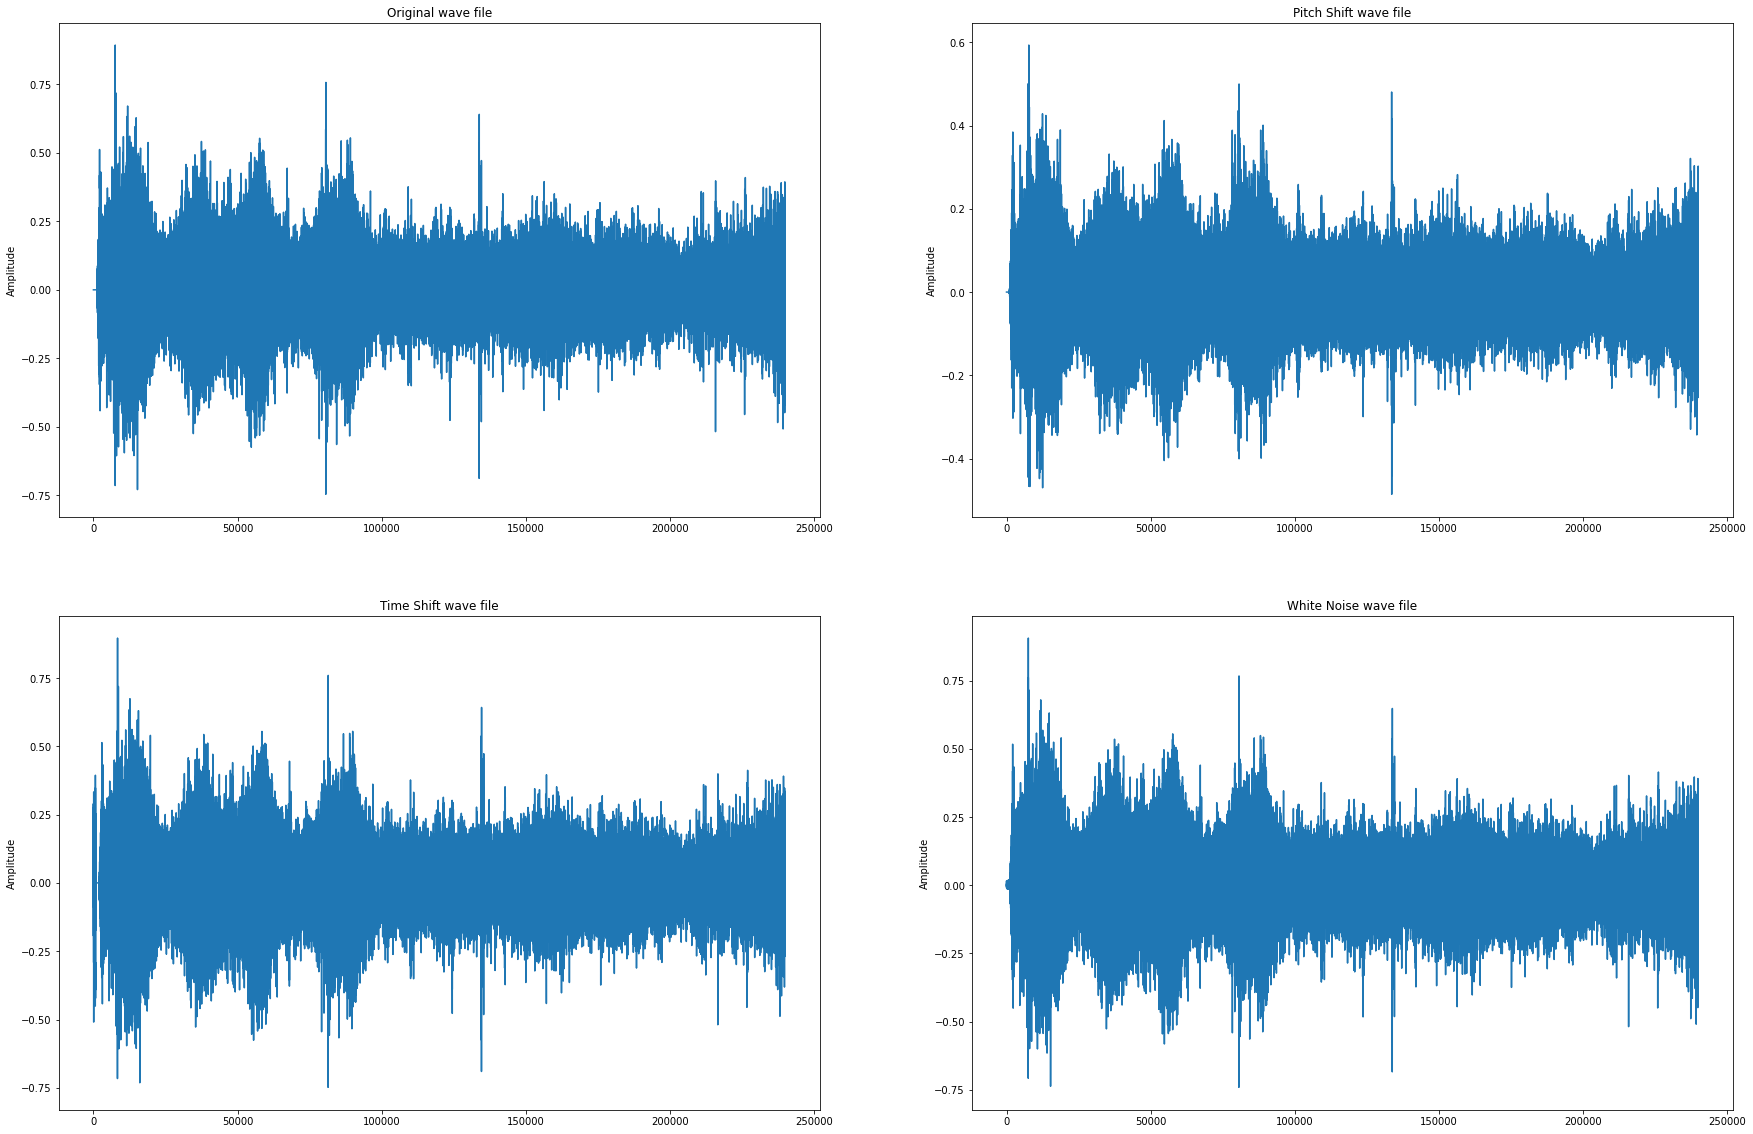

In [ ]:
def plot_spec(initial_data:np.array,initial_sr:int,aug_pitch_sf_data:np.array,pitch_sf_sr:int,aug_tsh_data:np.array,tsh_sr:int,aug_wn_data:np.array,wn_sr:int) -> None:
  '''
  Function for plotting spectrogram along with amplitude wave graph
  '''
  fig, ax = plt.subplots(2,2,figsize=(30,20))
  ax[0,0].title.set_text('Original wave file')
  ax[0,0].set_ylabel('Amplitude')
  ax[0,0].plot(initial_data)
  ax[0,1].title.set_text('Pitch Shift wave file')
  ax[0,1].set_ylabel('Amplitude')
  ax[0,1].plot(aug_pitch_sf_data)
  ax[1,0].title.set_text('Time Shift wave file')
  ax[1,0].set_ylabel('Amplitude')
  ax[1,0].plot(aug_tsh_data) 
  ax[1,1].title.set_text('White Noise wave file')
  ax[1,1].set_ylabel('Amplitude')
  ax[1,1].plot(aug_wn_data)    
plot_spec(initial_wav,sr,aug_pitch_sf_wav,pitch_sf_sr,aug_tsh_wav,tsh_sr,aug_wn_wav,wn_sr)

# Upload Augmented Training data

In [ ]:
# download the dataset (zipped file)
!wget --no-check-certificate \
    https://storage.googleapis.com/multimodal_training_augmented_data/training_augmented_data.zip \
    -O /tmp/training_augmented_data.zip

# extract the downloaded dataset to a local directory: /tmp
local_zip = '/tmp/training_augmented_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/dataset')
zip_ref.close()

--2021-07-07 12:28:55--  https://storage.googleapis.com/multimodal_training_augmented_data/training_augmented_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338401938 (323M) [application/x-zip-compressed]
Saving to: ‘/tmp/training_augmented_data.zip’

/tmp/training_augme 100%[===================>] 322.72M  76.0MB/s    in 4.6s    

2021-07-07 12:29:00 (70.1 MB/s) - ‘/tmp/training_augmented_data.zip’ saved [338401938/338401938]



# Feature Extraction

## Feature Extraction (Training)

In [ ]:
TrainingRecordingsPath='/tmp/dataset/training_augmented_data/'
# dictionary to store labels, and MFCCs
data_training = {
    "mfcc": [],
    "labels": []
    }
for recording in os.listdir(TrainingRecordingsPath):
  y, sr = librosa.load(TrainingRecordingsPath+recording,sr=8000)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
  mfcc = mfcc.T
  data_training["mfcc"].append(mfcc.tolist())
  partitioned_string = recording.partition('_')
  label = partitioned_string[0]
  if int(label) <= 5:
    data_training["labels"].append(0)
  elif int(label) <= 10:
    data_training["labels"].append(1)
  elif int(label) <= 15:
    data_training["labels"].append(2)
  elif int(label) <= 20:
    data_training["labels"].append(3)
  elif int(label) <= 15:
    data_training["labels"].append(4)
  elif int(label) <= 20:
    data_training["labels"].append(5)  
  elif int(label) <= 25:
    data_training["labels"].append(6)
  else:
    data_training["labels"].append(7)

## Feature Extraction (Test)

In [ ]:
ValidationRecordingsPath= '/tmp/dataset/Multimodal_Dataset/validation/'
# dictionary to store labels, and MFCCs
data_test = {
    "mfcc": [],
    "labels": []
    }
for recording in os.listdir(ValidationRecordingsPath):
  y, sr = librosa.load(ValidationRecordingsPath+recording,sr=8000)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
  mfcc = mfcc.T
  data_test["mfcc"].append(mfcc.tolist())
  partitioned_string = recording.partition('_')
  label = partitioned_string[0]
  if int(label) <= 5:
    data_test["labels"].append(0)
  elif int(label) <= 10:
    data_test["labels"].append(1)
  elif int(label) <= 15:
    data_test["labels"].append(2)
  elif int(label) <= 20:
    data_test["labels"].append(3)
  elif int(label) <= 15:
    data_test["labels"].append(4)
  elif int(label) <= 20:
    data_test["labels"].append(5)  
  elif int(label) <= 25:
    data_test["labels"].append(6)
  else:
    data_test["labels"].append(7)

## Convert lists to numpy arrays

In [ ]:
#convert lists to numpy arrays
X = np.array(data_training["mfcc"])
y = np.array(data_training["labels"])
X_test=np.array(data_test["mfcc"])
y_test = np.array(data_test["labels"])

In [ ]:
X.shape

(344, 469, 40)

## Build/Compile/Train the model

### With cross validation

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/35
7/7 [==============================] - 4s 209ms/step - loss: 2.0550 - accuracy: 0.1745 - val_loss: 2.0134 - val_accuracy: 0.1739
Epoch 2/35
7/7 [==============================] - 0s 70ms/step - loss: 2.0190 - accuracy: 0.1891 - val_loss: 1.9597 - val_accuracy: 0.3043
Epoch 3/35
7/7 [==============================] - 0s 69ms/step - loss: 1.9800 - accuracy: 0.2618 - val_loss: 1.9145 - val_accuracy: 0.3478
Epoch 4/35
7/7 [==============================] - 0s 68ms/step - loss: 1.8937 - accuracy: 0.2691 - val_loss: 1.8776 - val_accuracy: 0.3188
Epoch 5/35
7/7 [==============================] - 0s 70ms/step - loss: 1.8865 - accuracy: 0.2582 - val_loss: 1.8436 - val_accuracy: 0.3188
Epoch 6/35
7/7 [==============================] - 0s 68ms/step - loss: 1.8224 - accuracy: 0.3491 - val_loss: 1.8108 - val_accuracy: 0.3333
Epoch 7/35
7/7 [==============================] - 0s 69ms/step - los

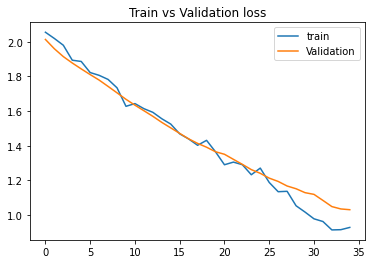

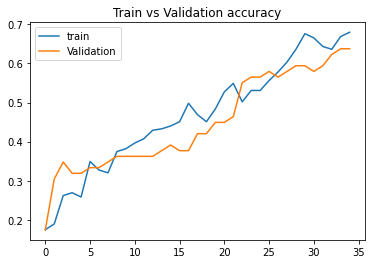

Score for fold 1: loss of 1.0314396619796753; accuracy of 63.76811861991882%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/35
7/7 [==============================] - 5s 214ms/step - loss: 2.1254 - accuracy: 0.1600 - val_loss: 1.9759 - val_accuracy: 0.2609
Epoch 2/35
7/7 [==============================] - 0s 68ms/step - loss: 2.0679 - accuracy: 0.1855 - val_loss: 1.9137 - val_accuracy: 0.3478
Epoch 3/35
7/7 [==============================] - 0s 69ms/step - loss: 1.9575 - accuracy: 0.2727 - val_loss: 1.8619 - val_accuracy: 0.4203
Epoch 4/35
7/7 [==============================] - 0s 70ms/step - loss: 1.9406 - accuracy: 0.2436 - val_loss: 1.8185 - val_accuracy: 0.4493
Epoch 5/35
7/7 [==============================] - 0s 70ms/step - loss: 1.8785 - accuracy: 0.2945 - val_loss: 1.7777 - val_accuracy: 0.4348
Epoch 6/35
7/7 [==============================] - 0s 69ms/step - loss: 1.8150 - accuracy: 0.3345 - val_loss: 1.7391 - val_accuracy

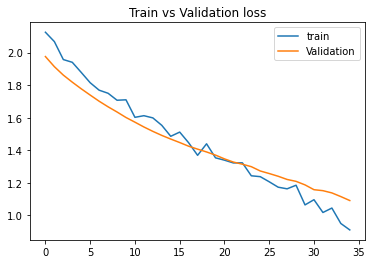

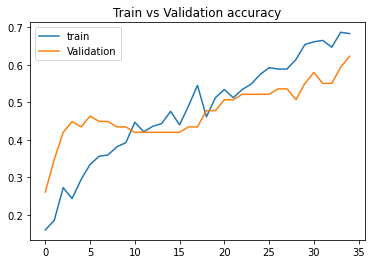

Score for fold 2: loss of 1.090800166130066; accuracy of 62.31883764266968%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/35
7/7 [==============================] - 4s 201ms/step - loss: 2.1464 - accuracy: 0.1055 - val_loss: 2.0421 - val_accuracy: 0.1739
Epoch 2/35
7/7 [==============================] - 0s 69ms/step - loss: 2.0460 - accuracy: 0.1855 - val_loss: 1.9876 - val_accuracy: 0.3913
Epoch 3/35
7/7 [==============================] - 0s 70ms/step - loss: 1.9837 - accuracy: 0.2400 - val_loss: 1.9404 - val_accuracy: 0.4348
Epoch 4/35
7/7 [==============================] - 0s 69ms/step - loss: 1.9362 - accuracy: 0.2655 - val_loss: 1.8979 - val_accuracy: 0.4058
Epoch 5/35
7/7 [==============================] - 0s 68ms/step - loss: 1.8783 - accuracy: 0.3418 - val_loss: 1.8545 - val_accuracy: 0.4348
Epoch 6/35
7/7 [==============================] - 0s 69ms/step - loss: 1.8044 - accuracy: 0.3745 - val_loss: 1.8094 - val_accuracy:

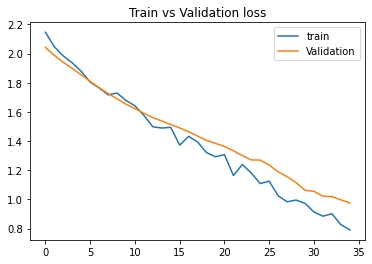

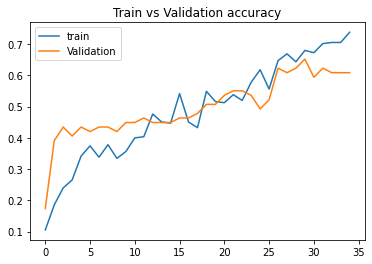

Score for fold 3: loss of 0.9758191108703613; accuracy of 60.86956262588501%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/35
7/7 [==============================] - 5s 320ms/step - loss: 2.1841 - accuracy: 0.1236 - val_loss: 2.0422 - val_accuracy: 0.2609
Epoch 2/35
7/7 [==============================] - 0s 69ms/step - loss: 2.0874 - accuracy: 0.1527 - val_loss: 1.9871 - val_accuracy: 0.2609
Epoch 3/35
7/7 [==============================] - 0s 69ms/step - loss: 2.0324 - accuracy: 0.2000 - val_loss: 1.9388 - val_accuracy: 0.3043
Epoch 4/35
7/7 [==============================] - 0s 70ms/step - loss: 1.9630 - accuracy: 0.1964 - val_loss: 1.8914 - val_accuracy: 0.3478
Epoch 5/35
7/7 [==============================] - 0s 69ms/step - loss: 1.9249 - accuracy: 0.2436 - val_loss: 1.8411 - val_accuracy: 0.3768
Epoch 6/35
7/7 [==============================] - 0s 69ms/step - loss: 1.9277 - accuracy: 0.2400 - val_loss: 1.7955 - val_accuracy

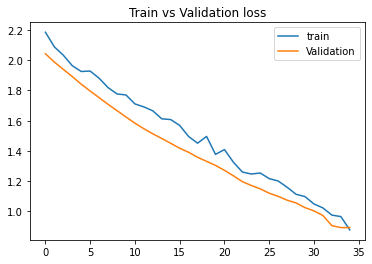

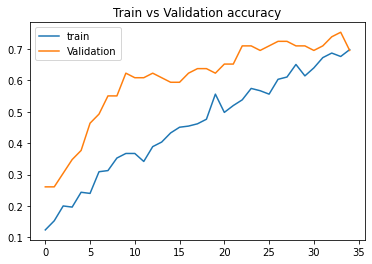

Score for fold 4: loss of 0.8941771388053894; accuracy of 69.5652186870575%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/35
7/7 [==============================] - 4s 201ms/step - loss: 2.1140 - accuracy: 0.1196 - val_loss: 2.0190 - val_accuracy: 0.1765
Epoch 2/35
7/7 [==============================] - 0s 69ms/step - loss: 2.0414 - accuracy: 0.1848 - val_loss: 1.9592 - val_accuracy: 0.2794
Epoch 3/35
7/7 [==============================] - 0s 68ms/step - loss: 2.0130 - accuracy: 0.2319 - val_loss: 1.9097 - val_accuracy: 0.3971
Epoch 4/35
7/7 [==============================] - 0s 69ms/step - loss: 1.9148 - accuracy: 0.2681 - val_loss: 1.8642 - val_accuracy: 0.4118
Epoch 5/35
7/7 [==============================] - 0s 67ms/step - loss: 1.8805 - accuracy: 0.2862 - val_loss: 1.8190 - val_accuracy: 0.4412
Epoch 6/35
7/7 [==============================] - 0s 69ms/step - loss: 1.8471 - accuracy: 0.2935 - val_loss: 1.7728 - val_accuracy:

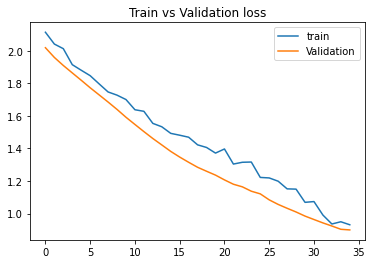

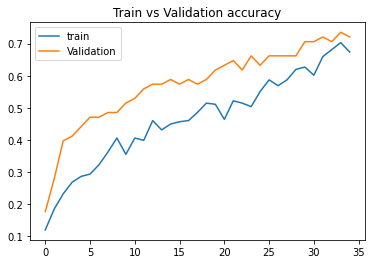

Score for fold 5: loss of 0.8993792533874512; accuracy of 72.0588207244873%
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0314396619796753 - Accuracy: 63.76811861991882%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.090800166130066 - Accuracy: 62.31883764266968%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9758191108703613 - Accuracy: 60.86956262588501%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.8941771388053894 - Accuracy: 69.5652186870575%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8993792533874512 - Accuracy: 72.0588207244873%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 65.71611166000366 (+- 4.

In [ ]:
import tensorflow.keras as keras
"""Generates LSTM model
:param input_shape (tuple): Shape of input set
:return model: LSTM model
"""
input_shape = (X.shape[1], X.shape[2])
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5,shuffle=True)
# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(X):
  X_train, X_val = X[train_index], X[test_index]
  y_train, y_val = y[train_index], y[test_index]
  # build network topology
  model = keras.Sequential()

  # 2 LSTM layers
  model.add(keras.layers.LSTM(128, input_shape=input_shape,return_sequences=True))
  model.add(keras.layers.LSTM(128))
  model.add(keras.layers.Dropout(0.4))

  # dense layer
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.5))

  # output layer
  model.add(keras.layers.Dense(8, activation='softmax'))

  # simple early stopping
  # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  # compile model
  optimiser = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimiser,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # model.summary()
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  # train model
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=40, epochs=35, verbose=1,callbacks=[es])
  
  # evaluate the model
  _, train_acc = model.evaluate(X_train, y_train, verbose=0)
  _, val_acc = model.evaluate(X_val, y_val, verbose=0)
  print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

  # plot loss - val loss
  plt.title("Train vs Validation loss")
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='Validation')
  plt.legend()
  plt.show()

  # plot accuracy - val accuracy
  plt.title("Train vs Validation accuracy")
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='Validation')
  plt.legend()
  plt.show()

  # Generate generalization metrics
  scores = model.evaluate(X_val, y_val, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', test_acc)

3/3 [==============================] - 0s 26ms/step - loss: 1.3935 - accuracy: 0.3721

Test accuracy: 0.3720930218696594


In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 469, 128)          86528     
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 520       
Total params: 226,888
Trainable params: 226,888
Non-trainable params: 0
_______________________________________________